# Speech Commands Classification

Final project of EECS 475 - Machine Learning  
**student name**: **Feiyu Chen**   
**time**: 2019, June 12th    
**video demo**: youtube TODO 

# Contents
1. Introduction
2. How to run the demo
3. Methods  
    3.1. Training data  
    3.2. Data augmentation  
    3.3. Features  
    3.4. Classifier  
4. Pretraining and Result
5. Finetuning and Result
6. Test
7. Conclusion


# 1. Introduction

The goal of this project is to implement an audio classification system, which: 
1. first reads in an audio clip (containing at most one word),
2. and then recognizes the class(label) of this audio.


### Classes  
11 classes are chosen, namely:   
> one, two, three, four, five, front, back, left, right, stop, none

where "one" means the audio contains the word "one", etc. The only exception is that "none" means the audio contains no word.

### Method  

Features: MFCCs (Mel-frequency cepstral coefficients) are computed from the raw audio. You can think of it as the result of fouriour transformation.

Classifier: LSTM (Long Short-Term Memory) is adopted for classificatioin, which is a type of Recurrent Neural Network.

The model was pretrained on the [Speech Commands Dataset](https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html) with intensive data augmentation, including "shift", "amplify", "superpose noise", etc.

The model was then finetuned on my own dataset.
    
### Result  

The test accuracy is 92.4% on Speech Commands Dataset, with a random 0.9/0.1 train/test split.

The model was was then evaluated on my own dataset of 1378 samples.  
The test accuracy is 100.0%, with a random 0.7/0.3 train/test split.  

# 2. How to run the demo

* Inference from microphone:
    1. Run the main program:  
        > $ python src/s3_inference_microphone.py
    2. Press "r" on your keyboard to start recording the audio.
    3. Say a word among the above 10 words, or say nothing.
    4. Release the key "r" to stop recording.
    5. The program will speak out the recognition result.

* Inference an audio file:  
    For example:
    > $ python src/s4_inference_audio_file.py --path_to_data test_data/audio_front.wav

* Inference a folder containing audio files:  
    For example:
    > $ python src/s4_inference_audio_file.py --path_to_data data/data_train/three/

In [1]:
# Setup things for running this notebook

%load_ext autoreload
%autoreload 2

import sys, os
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy
import copy 
import torch

# display
import IPython.display as ipd
from IPython.core.display import HTML
from IPython.display import display, clear_output


# audio library
import librosa.display 

# Import all my libraries
import utils.lib_io as lib_io
import utils.lib_commons as lib_commons
import utils.lib_datasets as lib_datasets
import utils.lib_augment as lib_augment
import utils.lib_ml as lib_ml
import utils.lib_rnn as lib_rnn

# 3. Methods

## 3.1. Training data   

Two datasets are used: 
1. "Speech Commands Dataset" for pretraining.
2. My own dataset for finetuning.


### 3.1.1. Speech Commands Dataset (105k samples, 35 classes)
[Speech Commands Dataset](https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html) contains **105k audio clips** (3.3GB large) collected from lots of people.  
It has **35 classes** of words, listed as follows:  
(The folder is named as "kaggle" because Kaggle once hold a competition on this dataset, and "kaggle" is shorter than "Speech Commands Dataset" ^_^ )

In [2]:
ls data/kaggle

ls: cannot access 'data/kaggle': No such file or directory


These large amount of data are important for extracting the core features of a word.  
If I didn't do the pretraining on this dataset, the model will have poor performance when generalizing to other people's voices.

### 3.1.2. My dataset  (1378 samples, 11 classes)
My dataset were recorded by myself. It has 1378 audio clips of the 11 target classes listed as follows:  

In [3]:
ls data/data_train

back/  five/  four/  front/  left/  none/  one/  right/  stop/  three/  two/


**Details of the data:**  
    The audios were recorded by my laptop's built-in microphone as well as an external microphone. I collected these data in different days, so the voice, loudness, and background noise were varied. Besides, I also put 40 synthesized audios (by gttS package) into the training data.
    
**Example audio:**  
To avoid the trouble of downloading my whole dataset, I've already copied a sample to the "test_data/" folder.

In [4]:
#audio = lib_datasets.AudioClass(filename="data/data_train/front/audio_05-09-01-53-47-319dge0sjk5.wav")
audio = lib_datasets.AudioClass(filename="test_data/audio_front.wav")
ipd.Audio(audio.data, rate=audio.sample_rate) # play audio

## 3.2. Data augmentation

Raw data goes through a serials of augmentation before training, including:  
> Shift  
> Pad zeros  
> Amplify  
> Change play speed  
> Superpose noise  

This step is essential. Raw audios in Speech Commands Dataset are all about 1 second long, and have little background noise. It can easily causes certain overfitting.  

We should try to diversify the data by data augmentation techniques, in order to get prepared for all kinds of real-world scenarios, including noise, variation of the audio length and loudness. 

**Example of audio augmentation:**

In [5]:
# Initialize the augmenter.
#     Specify a parameter's range for generating a random augmentation.

Aug = lib_augment.Augmenter
aug = Aug([        
    
    Aug.Shift(rate=(0, 0.2), keep_size=False), # shift data for 0~0.2 percent of the total length
    
    Aug.PadZeros(time=(0, 0.3)),  # pad zeros at one side for 0~0.3 seconds 
    
    Aug.Amplify(rate=(0.2, 1.5)), # amplify loudness by 0.2~1.5 
    
    Aug.PlaySpeed(rate=(0.7, 1.3), keep_size=False), # change play speed
    
    Aug.Noise( # Superpose noise.
        # (Noise files are pre-load and normalized)
        noise_folder="data/noises/", prob_noise=1.0, intensity=(0, 0.7)),

], prob_to_aug=1.0, # probability to do this augmentation
)

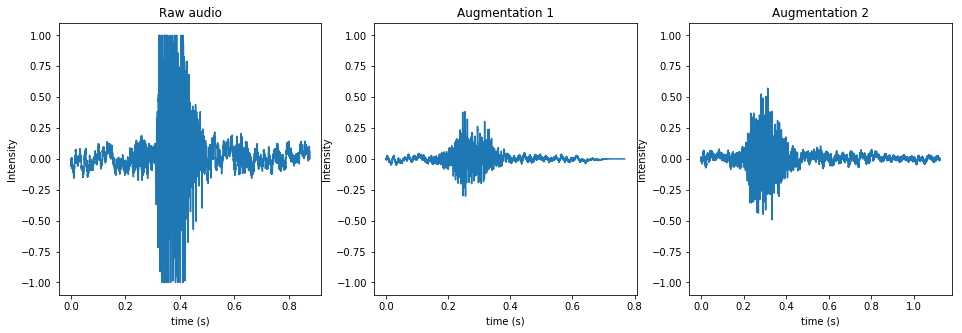

In [6]:
# Read audio, do two different augmentations, and plot results

plt.figure(figsize=(16, 5))

plt.subplot(131)
audio_1 = lib_datasets.AudioClass(filename="test_data/audio_front.wav")
audio_1.plot_audio(ax=plt.gca())
plt.title("Raw audio")

plt.subplot(132)
audio_2 = copy.deepcopy(audio_1)
aug(audio_2) # augment audio
audio_2.plot_audio(ax=plt.gca())
plt.title("Augmentation 1")

plt.subplot(133)
audio_3 = copy.deepcopy(audio_1)
aug(audio_3) # augment audio
audio_3.plot_audio(ax=plt.gca())
plt.title("Augmentation 2")

plt.show()

In [7]:
ipd.Audio(audio_1.data, rate=audio_1.sample_rate) # play audio

In [8]:
ipd.Audio(audio_2.data, rate=audio_2.sample_rate)

In [9]:
ipd.Audio(audio_3.data, rate=audio_3.sample_rate)

**Noise files for audio augmentation:**

In [10]:
ls data/noises

air_conditioner.wav   forest_2.wav    running_tap.wav  white_4.wav
doing_the_dishes.wav  music.wav       water.wav        white_5.wav
dude_miaowing.wav     pink_noise.wav  white_1.wav      white_noise.wav
exercise_bike.wav     rain.wav        white_2.wav      wind.wav
forest_1.wav          README.md       white_3.wav


In [11]:
audio_noise = lib_datasets.AudioClass(filename="data/noises/rain.wav")
ipd.Audio(audio_noise.data, rate=audio_noise.sample_rate) # play audio

## 3.3. Features
The [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) feature is computed and fed into the classifer.

An intuitive understanding of MFCCs is: Use a sliding window on the raw data, and compute the fourior transform of each window to obtain the "loudness" on each frequency band.

The code and parameters for computing MFCCs is:

``` python
def compute_mfcc(data, sample_rate, n_mfcc=12):
    return librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=n_mfcc)
```

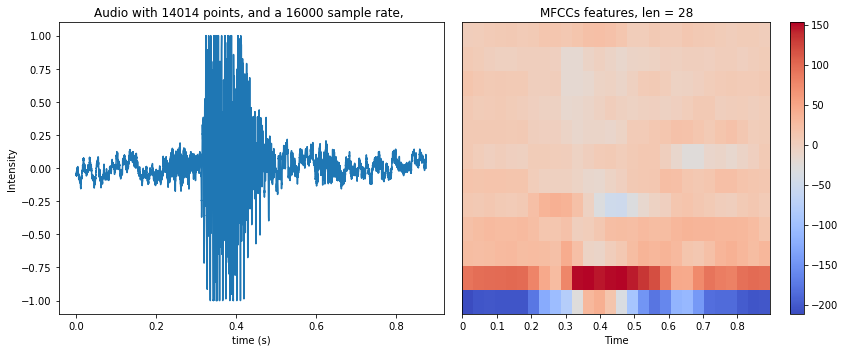

In [12]:
# A visualization of the MFCCs features is shown below:
audio.compute_mfcc()
audio.plot_audio_and_mfcc()
plt.show()

* Histogram of MFCCs is a bad feature  
I also tested the feature of "the histogram of MFCCs", but the performance is bad, since the information of time length is lost.  
A histogram feature is shown below. It's computed piece-wisely of 3 pieces on a MFCCs:

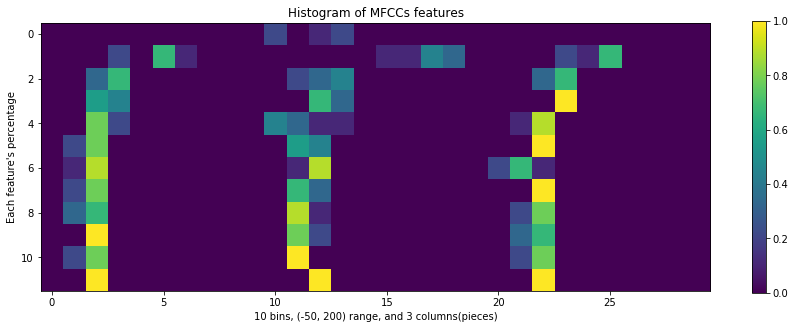

In [13]:
audio.compute_mfcc_histogram(bins=10, binrange=(-50, 200), col_divides=3)
audio.plot_mfcc_histogram() # After experiment, I found that this feature is bad. Don't use it.

# 3.4. Classifier
The input audio has a varying length, thus the feature's length also varies.  
To deal with such cases, I adopted the LSTM (Long short-term memory) for classification.  
The main paramters are set as: 3 layers and 64 states in each layer.  
The code is copied from [here](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/recurrent_neural_network/main.py).

``` python

# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, device):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.device = device

    def forward(self, x):
        # Set initial hidden and cell states
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) 
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) 
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # shape = (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out
```
see [utils/lib_rnn.py](utils/lib_rnn.py) for more details.

# 4. Pretraining and Result

The model was pretrained on the Speech Commands Dataset.

## Settings
	num_epochs          : 25
	learning_rate       : 0.001
	train_eval_test_ratio: [0.9, 0.1, 0.0]
	
    aug = Aug([        
        Aug.Shift(rate=0.2, keep_size=False), 
        Aug.PadZeros(time=(0, 0.3)),
        Aug.Amplify(rate=(0.2, 1.5)),
        # Aug.PlaySpeed(rate=(0.7, 1.3), keep_size=False),
        Aug.Noise(noise_folder="data/noises/", 
                        prob_noise=0.7, intensity=(0, 0.7)),
    ], prob_to_aug=0.8)
    
For more details about the settings and result,  
please see [good_weights/kaggle/log.txt](good_weights/kaggle/log.txt)

## Result
<img src="good_weights/kaggle/fig.jpg" alt="Accuracy" width="800"/>


Since epoch 23 gives the highest testing accuracy of [92.4%](good_weights/kaggle/log.txt), the corresponding weight file is used for finetuning.

The weight file is put to "good_weights/kaggle.ckpt"


* Notes: 
    * Testing accuracy is higher than training accuracy because the training set were data augmented and were harder to classify.  
    * The optimizer is Adam. Based on some tutorials, the weight decay is as 0 for Adam.

# 5. Finetuning and Result

The pretrained weight is then fine-tuned on my own dataset. All weights all fixed except the last fully-connected layer.

## Settings
	num_epochs          : 10
	learning_rate       : 0.001
    train_eval_test_ratio: [0.7, 0.3, 0.0]

    aug = Aug([
        Aug.Shift(rate=0.2, keep_size=False), 
        Aug.PadZeros(time=(0, 0.3)),
        Aug.Amplify(rate=(0.5, 1.2)),
    ], prob_to_aug=0.8)

For more details, please see [good_weights/my/log.txt](good_weights/my/log.txt)

## Result
<img src="good_weights/my/fig.jpg" alt="Accuracy" width="800"/>

    Accuracies:
        Epoch     Train     Eval      
        1         0.760     0.969    
        2         0.965     0.990   
        3         0.985     0.990   
        4         0.991     0.995   
        5         0.996     0.998     
        6         0.996     0.998  
        7         0.999     0.998  
        8         0.998     0.995    
        9         1.000     1.000     
        10        0.999     0.998   


Since epoch 9 gives the highest testing accuracy of 100.0%, the corresponding weight file is used as the final weight.  
The weight file is put to "good_weights/my.ckpt"

# 5.5 Without data augmentation when pretraining on Speech Commands Dataset

A comparison study has been made, where the model is pretrained without data augmentation.   
All the other settings are kept the same.

The result is shown below, where the accuracies decreased a little bit:

```
Pretraining:
	Epoch     Train     Eval      Test        
	21        0.978     0.914     -0.100    
    
Finetuning:
	Epoch     Train     Eval      Test      
	10        0.998     0.981     -0.100    
```

See these files for more details:  
[good_weights/no_augment_on_kaggle/kaggle/fig.jpg](good_weights/no_augment_on_kaggle/kaggle/fig.jpg)  
[good_weights/no_augment_on_kaggle/kaggle/log.txt](good_weights/no_augment_on_kaggle/kaggle/log.txt)  
[good_weights/no_augment_on_kaggle/my/fig.jpg](good_weights/no_augment_on_kaggle/my/fig.jpg)  
[good_weights/no_augment_on_kaggle/my/log.txt](good_weights/no_augment_on_kaggle/my/log.txt)  


# 6. Test
Let's test the model on an audio file:

In [14]:
# Load model

def setup_classifier(load_weights_from):
    model_args = lib_rnn.set_default_args()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = lib_rnn.create_RNN_model(model_args, load_weights_from)
    return model

def setup_classes_labels(load_classes_from, model):
    classes = lib_io.read_list(load_classes_from)
    print(f"{len(classes)} classes: {classes}")
    model.set_classes(classes)
    
model = setup_classifier(load_weights_from="good_weights/my.ckpt")
setup_classes_labels(load_classes_from="config/classes.names", model=model)

Load weights from: good_weights/my.ckpt
11 classes: ['one', 'two', 'three', 'four', 'five', 'front', 'back', 'left', 'right', 'stop', 'none']


In [15]:
# Test on an audio "front"

audio_1 = lib_datasets.AudioClass(filename="test_data/audio_front.wav")
label = model.predict_audio_label(audio)
print(f"Predicted label is: {label}")

Predicted label is: front


# 7. Conclusion

In this project, I trained a machine learning model for audio classification.

For classification, the MFCCs are used as features, and the LSTM is the classifier. The model was pre-trained on Speech Commands Dataset with intensive data augmentation. The model was then finetuned on my own dataset with 1.3k samples and 11 classes. 

The model achieves **92.4%** accuracy on the Speech Commands Dataset,  
and **100%** accuracy on my own dataset, which is perfect.

I've also let my friends try my program, and the recognition result was good: 7 out of 8 trials were correct. You may try it by yourself!